<a href="https://colab.research.google.com/github/GwiYeonKim/modulabs_repository/blob/main/%EB%8D%B0%EC%8B%B84%EA%B8%B0_%ED%9A%8C%EA%B7%80_%EC%A7%91%EA%B0%92%EC%98%88%EC%B8%A1_%EA%B9%80%EA%B7%80%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 참여 링크

https://www.kaggle.com/t/05f287fe67bb43298d8c3e66a1e71c27

# House Prices 🏠

## 데이터 불러오기
- Colab의 기본 작업 디렉토리는 /content 임.
- /content/Modulabs 디렉토리 생성하여 데이터 파일 업로드함.

### 라이브러리 및 데이터 불러오기

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('Modulabs/train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


### 데이터 확인
 - 총 81개의 피처로 구성됨.
 - Null 컬럼이 19개로 많은 비중을 차지함.

In [5]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtCond          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
dtype: int64


- Target = Sale Price 의 분포 확인

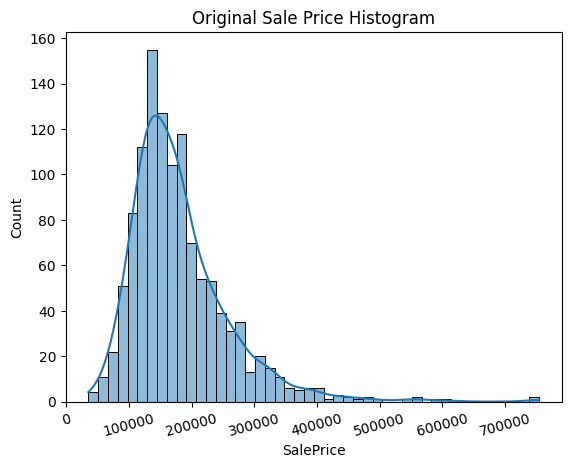

In [6]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

로그 씌워보기

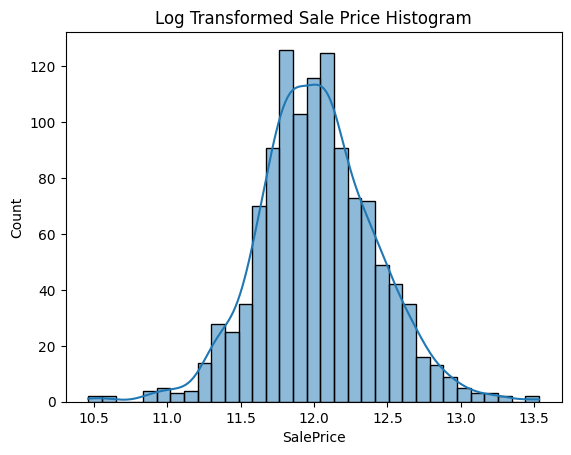

In [7]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

### 결측치 처리
- 범주형 데이터

In [8]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 1000개 이상인 컬럼 삭제
# house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley'], axis=1 , inplace=True)


In [9]:
house_df['Fence'].value_counts()

,count
Fence,
MnPrv,127
GdWo,47
GdPrv,46
MnWw,7


In [10]:
## 1. 'Fence' 결측치를 최빈값으로 채움
house_df['Fence'] = house_df['Fence'].fillna('MnPrv')

In [11]:
# 2. 'MasVnrType'은 외장 석재를 말하며, 결측치는 외장석재가 없음을 의미하므로 'None으로 처리
house_df['MasVnrType'].value_counts()

,count
MasVnrType,
BrkFace,359
Stone,104
BrkCmn,11


In [12]:
house_df['MasVnrType'] = house_df['MasVnrType'].fillna('None')
house_df['MasVnrArea'] = house_df['MasVnrArea'].fillna(0)

In [13]:
# 3. FireplaceQu (벽난로 품질)
# - 결측치 의미: 벽난로가 없음 (즉, 품질이 없는 것이 아니라, 벽난로 자체가 없음)
# 처리 방법: 'None'으로 채우기
house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna('None')

In [14]:
# 4. LotFrontage (도로에 접한 거리)
# - 측치 의미: 실제 측정 누락 또는 존재하지 않음
# 처리 방법: 동일한 Neighborhood(이웃 지역) 단위의 평균값으로 채우기
# 이웃 지역별 평균 LotFrontage로 결측치 채우기
house_df['LotFrontage'] = house_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

In [15]:
# 5. Garage 관련 (69건씩 결측)
# GarageType, GarageFinish, GarageQual, GarageCond	: 차고의 유형, 마감, 품질 등 => 'None' 으로 채우기
# GarageYrBlt	: 차고 건축 연도 => 0 또는 집의 건축연도(YearBuilt)로 채우기

# 범주형은 'None'으로
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
house_df[garage_cols] = house_df[garage_cols].fillna('None')

# GarageYrBlt는 0 또는 YearBuilt 사용
house_df['GarageYrBlt'] = house_df['GarageYrBlt'].fillna(0)

In [16]:
# 6. Basement 관련 결측치 - 지하실 없음
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
house_df[bsmt_cols] = house_df[bsmt_cols].fillna('None')

In [17]:
# 7. Electrical - 최빈값으로 채움 (1건 결측)
house_df['Electrical'] = house_df['Electrical'].fillna(house_df['Electrical'].mode()[0])

In [18]:
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수:
  Series([], dtype: int64)


- 숫자형 데이터

In [19]:
# 데이터 형태 확인
pd.set_option('display.max_columns', None)
house_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.00000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.97774,70.203339,10336.357877,6.105308,5.595890,1971.201199,1985.021404,102.233733,442.928938,42.537671,574.708904,1060.175514,1161.748288,344.853596,5.094178,1511.696062,0.425514,0.058219,1.562500,0.388699,2.865582,1.047089,6.511130,0.625856,1861.529966,1.761130,469.888699,90.971747,47.554795,22.715753,3.219178,16.332192,2.955479,51.279110,6.306507,2007.830479,12.020568
std,42.29068,22.799120,8784.854640,1.373032,1.127388,30.362445,20.693264,175.743184,462.364719,151.670697,440.959454,439.223929,392.662227,438.502580,44.876004,535.707765,0.518319,0.241463,0.551882,0.506624,0.824796,0.223722,1.639763,0.654232,467.268820,0.746517,213.604836,123.811685,68.250085,63.042971,29.241246,58.828037,41.648504,552.357575,2.715955,1.323583,0.398863
min,20.00000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460271
25%,20.00000,60.000000,7560.000000,5.000000,5.000000,1954.000000,1966.750000,0.000000,0.000000,0.000000,233.000000,793.000000,880.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.771444
50%,50.00000,70.000000,9446.000000,6.000000,5.000000,1972.500000,1994.000000,0.000000,374.500000,0.000000,485.500000,990.000000,1077.500000,0.000000,0.000000,1456.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,477.500000,0.000000,25.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.007597
75%,70.00000,80.000000,11601.500000,7.000000,6.000000,2001.000000,2004.000000,166.250000,714.500000,0.000000,813.250000,1306.000000,1392.500000,728.000000,0.000000,1774.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.250000,2.000000,576.000000,165.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.269345
max,190.00000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1170.000000,5644.000000,1474.000000,2153.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534474


In [20]:
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
# house_df.fillna(house_df.mean(),inplace=True)
num_cols = house_df.select_dtypes(include=['number']).columns
num_cols
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].mean())


# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 Series([], dtype: object)


In [21]:
house_df.shape

(1168, 77)

In [22]:
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수:
  Series([], dtype: int64)


### 원핫인코딩
 - 타겟 분포가 더 정규 분포에 가까워지고, 이상치 영향도 감소하여 전체적으로 모델 학습에 적합한 분포 형성을 기대한다.

In [23]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

#get_dummies() 수행 전 데이터 Shape: (1168, 75) --> (1168, 77)
#get_dummies() 수행 후 데이터 Shape: (1168, 267)  --> (1168, 287)
## Null 피처의 Type :
# Series([], dtype: object)

get_dummies() 수행 전 데이터 Shape: (1168, 77)
get_dummies() 수행 후 데이터 Shape: (1168, 287)
## Null 피처의 Type :
 Series([], dtype: object)


In [24]:
house_df_ohe

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,Garage

### 이상치 처리

In [25]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
BsmtHalfBath      4.133732
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.545007
OpenPorchSF       2.454159
MasVnrArea        2.420783
BsmtFinSF1        1.881057
TotalBsmtSF       1.864686
WoodDeckSF        1.546567
1stFlrSF          1.488257
GrLivArea         1.474257
MSSubClass        1.391605
dtype: float64


In [26]:
# 왜도가 높은 수치형 피처들에 대해 로그 변환
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용
house_df_ohe = pd.get_dummies(house_df)

### 데이터 나누기

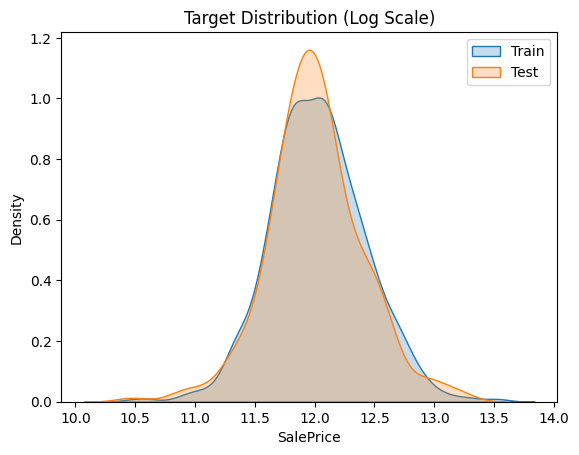

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#  피처/타겟 데이터 셋 생성,
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.legend()
plt.title('Target Distribution (Log Scale)')
plt.show()

# # 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
# ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
# lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
# best_ridge = print_best_params(ridge_reg, ridge_params)
# best_lasso = print_best_params(lasso_reg, lasso_params)

## 선형 회귀 모델 학습/예측/평가

함수 정의

In [30]:
# 평가 함수 정의
def get_rmse(model):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    mse2 = mean_squared_error(y_test , pred)
    rmse0 = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(np.sqrt(mse2), 3)))
    print('{0} 로그 변환된 MSE: {1}'.format(model.__class__.__name__,np.round(mse2, 3)))

    print('{0} 로그 변환해제 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse0, 3)))
    print('{0} 로그 변환해제 MSE: {1}'.format(model.__class__.__name__,np.round(mse, 3)))

    return rmse0

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [31]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

In [32]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

In [33]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

In [34]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_



In [46]:
def get_fit_params_with_early_stopping(model, X_train, X_test, y_train, y_test):
    """
    LightGBM 또는 XGBoost 모델의 학습 시 조기 종료(Early Stopping)를 적용하기 위한
    fit() 파라미터 딕셔너리를 생성하여 반환한다.

    GridSearchCV 또는 RandomizedSearchCV의 fit() 호출 시 fit_params 인자로 사용된다.

    Parameters
    ----------
    model : 학습 대상 모델 객체
    X_train, X_test, y_train, y_test : 학습/검증 데이터

    Returns
    -------
    fit_params : dict
        모델 학습 시 fit()에 전달할 파라미터
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMRegressor):
        return {
            'eval_set': eval_set,
            'eval_metric': 'rmse',
            'callbacks': [
                early_stopping(stopping_rounds=50, verbose=False),
                log_evaluation(period=0)
            ]
        }

    elif isinstance(model, XGBRegressor):
        return {
            'eval_set': eval_set,
            'verbose': False
        }

    else:
        return {}  # 일반 회귀 모델은 특별한 fit_params 필요 없음

In [53]:
def evaluate_best_model(grid_cv, X_test, y_test):
    """
    GridSearchCV/RandomizedSearchCV로 튜닝된 최적 회귀 모델을
    테스트 세트에 대해 평가하고, 주요 회귀 지표를 출력한다.

    Parameters
    ----------
    grid_cv : GridSearchCV 또는 RandomizedSearchCV 객체
        사전에 fit()이 완료된 객체로, 최적 모델(best_estimator_)을 포함하고 있어야 함
    X_test : array-like of shape (n_samples, n_features)
        테스트 피처 (원핫 인코딩 상태)
    y_test : array-like of shape (n_samples,)
        테스트 타겟 (log 변환 상태)

    Prints
    ------
    - 최적 하이퍼파라미터 (best_params_)
    - 교차 검증 기반 최고 성능 (neg-MSE 기준)
    - 로그 복원된 테스트 세트에 대한 RMSLE, RMSE, MSE
    """

    print('Best Hyperparameters:', grid_cv.best_params_)
    print('Best Cross-Validation Score (neg-MSE 기준):', grid_cv.best_score_)

    best_model = grid_cv.best_estimator_
    pred = best_model.predict(X_test)

    # 로그 복원
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)

    print('\nTest Evaluation')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test_exp, pred_exp)):.4f}')
    print(f'MSE  : {mean_squared_error(y_test_exp, pred_exp):.4f}')

    return best_model

### 일반 선형 모델

LinearRegression 로그 변환된 RMSE: 0.127
LinearRegression 로그 변환된 MSE: 0.016
LinearRegression 로그 변환해제 RMSE: 20566.533
LinearRegression 로그 변환해제 MSE: 422982272.685
Ridge 로그 변환된 RMSE: 0.116
Ridge 로그 변환된 MSE: 0.013
Ridge 로그 변환해제 RMSE: 21701.66
Ridge 로그 변환해제 MSE: 470962055.133
Lasso 로그 변환된 RMSE: 0.112
Lasso 로그 변환된 MSE: 0.012
Lasso 로그 변환해제 RMSE: 22166.286
Lasso 로그 변환해제 MSE: 491344232.76

LinearRegression CV RMSE 값 리스트: [0.189 0.161 0.111 0.124 0.112]
LinearRegression CV 평균 RMSE 값: 0.14

Ridge CV RMSE 값 리스트: [0.159 0.148 0.117 0.122 0.113]
Ridge CV 평균 RMSE 값: 0.132

Lasso CV RMSE 값 리스트: [0.16  0.142 0.115 0.117 0.107]
Lasso CV 평균 RMSE 값: 0.128
Ridge 5 CV 시 최적 평균 RMSE 값: 0.1333, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1297, 최적 alpha:{'alpha': 0.001}


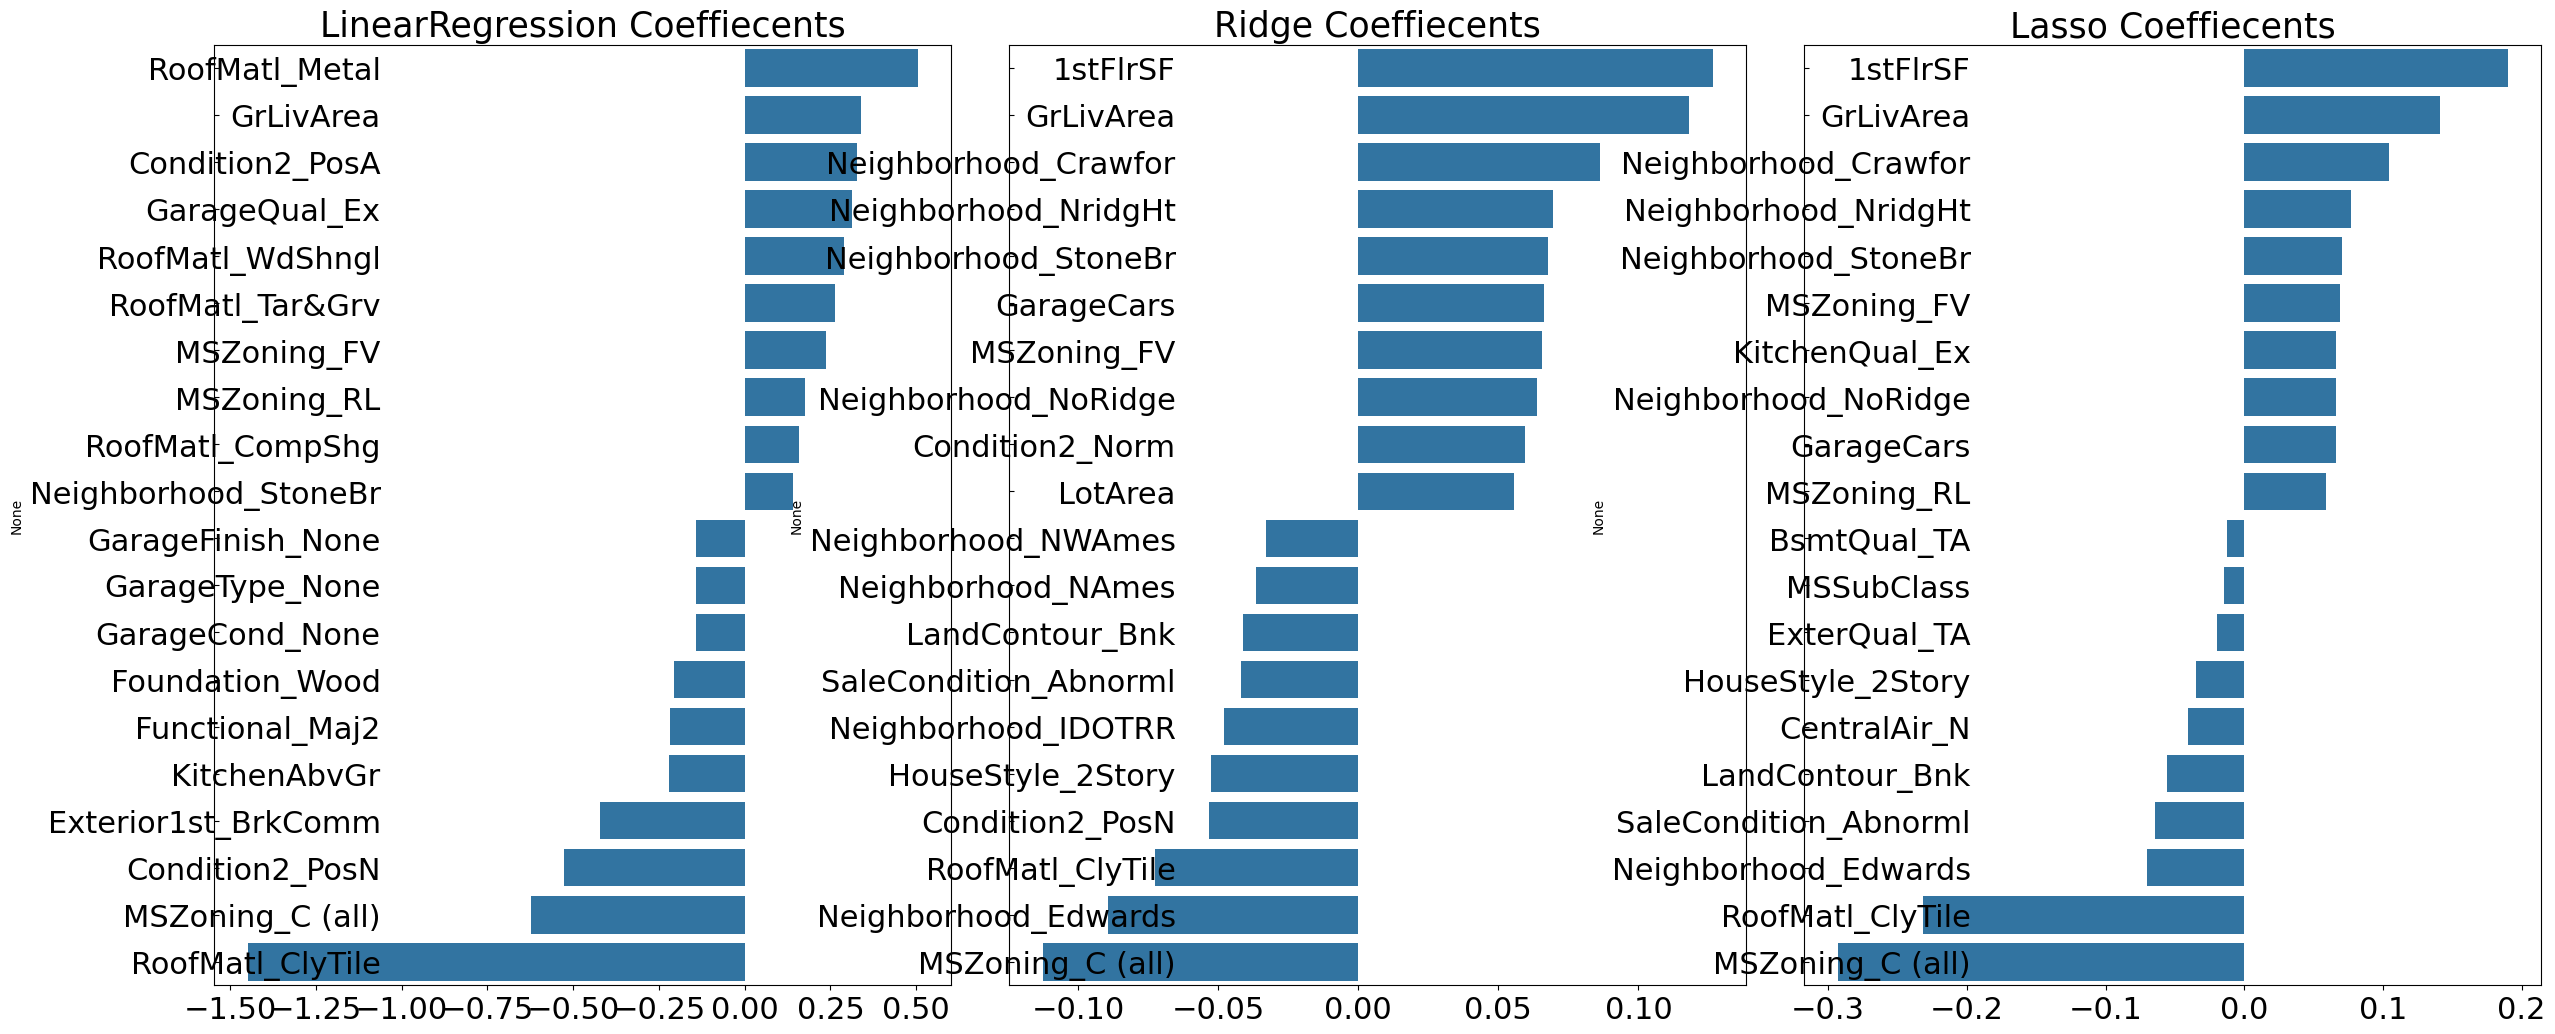

In [36]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

### LinearRegression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

### Ridge
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)


### LASSO
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
get_avg_rmse_cv(models)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

LinearRegression 로그 변환된 RMSE: 0.127
LinearRegression 로그 변환된 MSE: 0.016
LinearRegression 로그 변환해제 RMSE: 20566.533
LinearRegression 로그 변환해제 MSE: 422982272.685
Ridge 로그 변환된 RMSE: 0.116
Ridge 로그 변환된 MSE: 0.013
Ridge 로그 변환해제 RMSE: 21563.22
Ridge 로그 변환해제 MSE: 464972473.15
Lasso 로그 변환된 RMSE: 0.112
Lasso 로그 변환된 MSE: 0.012
Lasso 로그 변환해제 RMSE: 22166.286
Lasso 로그 변환해제 MSE: 491344232.76


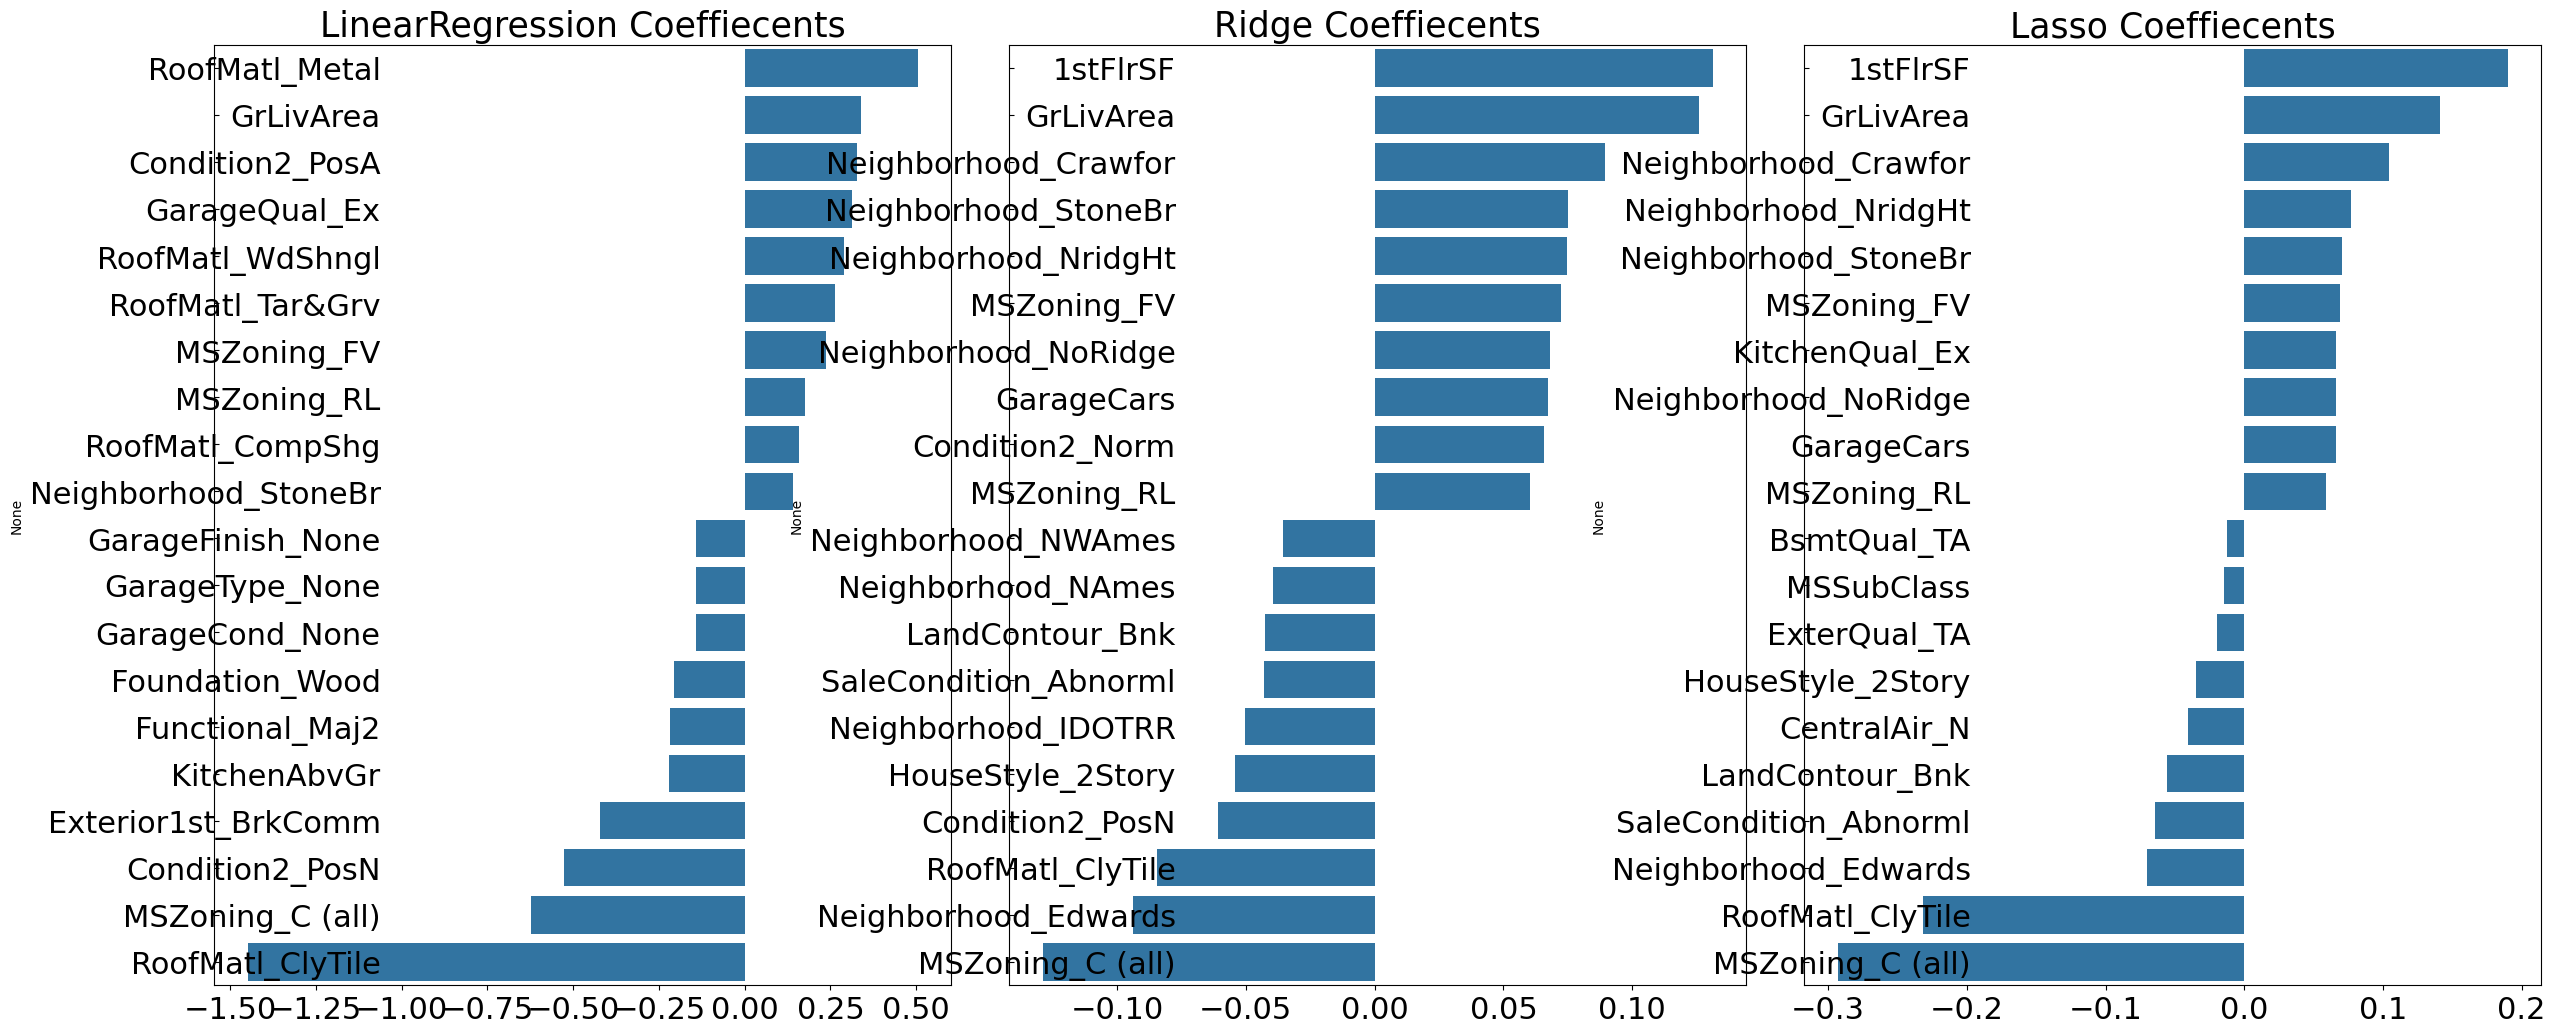

In [38]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

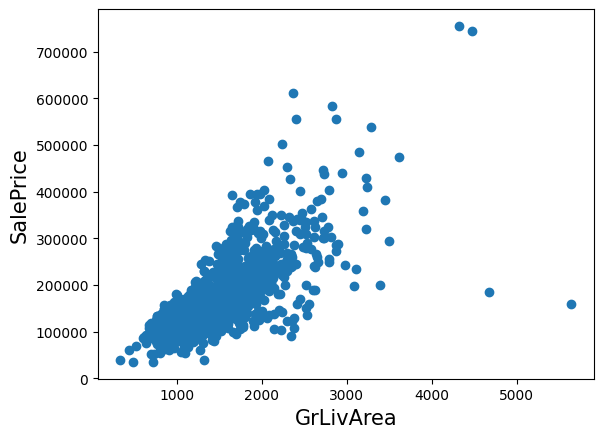

In [39]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [40]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 64 373]
아웃라이어 삭제 전 house_df_ohe shape: (1168, 287)
아웃라이어 삭제 후 house_df_ohe shape: (1166, 287)


In [41]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1152, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1131, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.123
LinearRegression 로그 변환된 MSE: 0.015
LinearRegression 로그 변환해제 RMSE: 21584.601
LinearRegression 로그 변환해제 MSE: 465895012.78
Ridge 로그 변환된 RMSE: 0.116
Ridge 로그 변환된 MSE: 0.014
Ridge 로그 변환해제 RMSE: 21218.182
Ridge 로그 변환해제 MSE: 450211247.348
Lasso 로그 변환된 RMSE: 0.112
Lasso 로그 변환된 MSE: 0.013
Lasso 로그 변환해제 RMSE: 20325.727
Lasso 로그 변환해제 MSE: 413135164.589


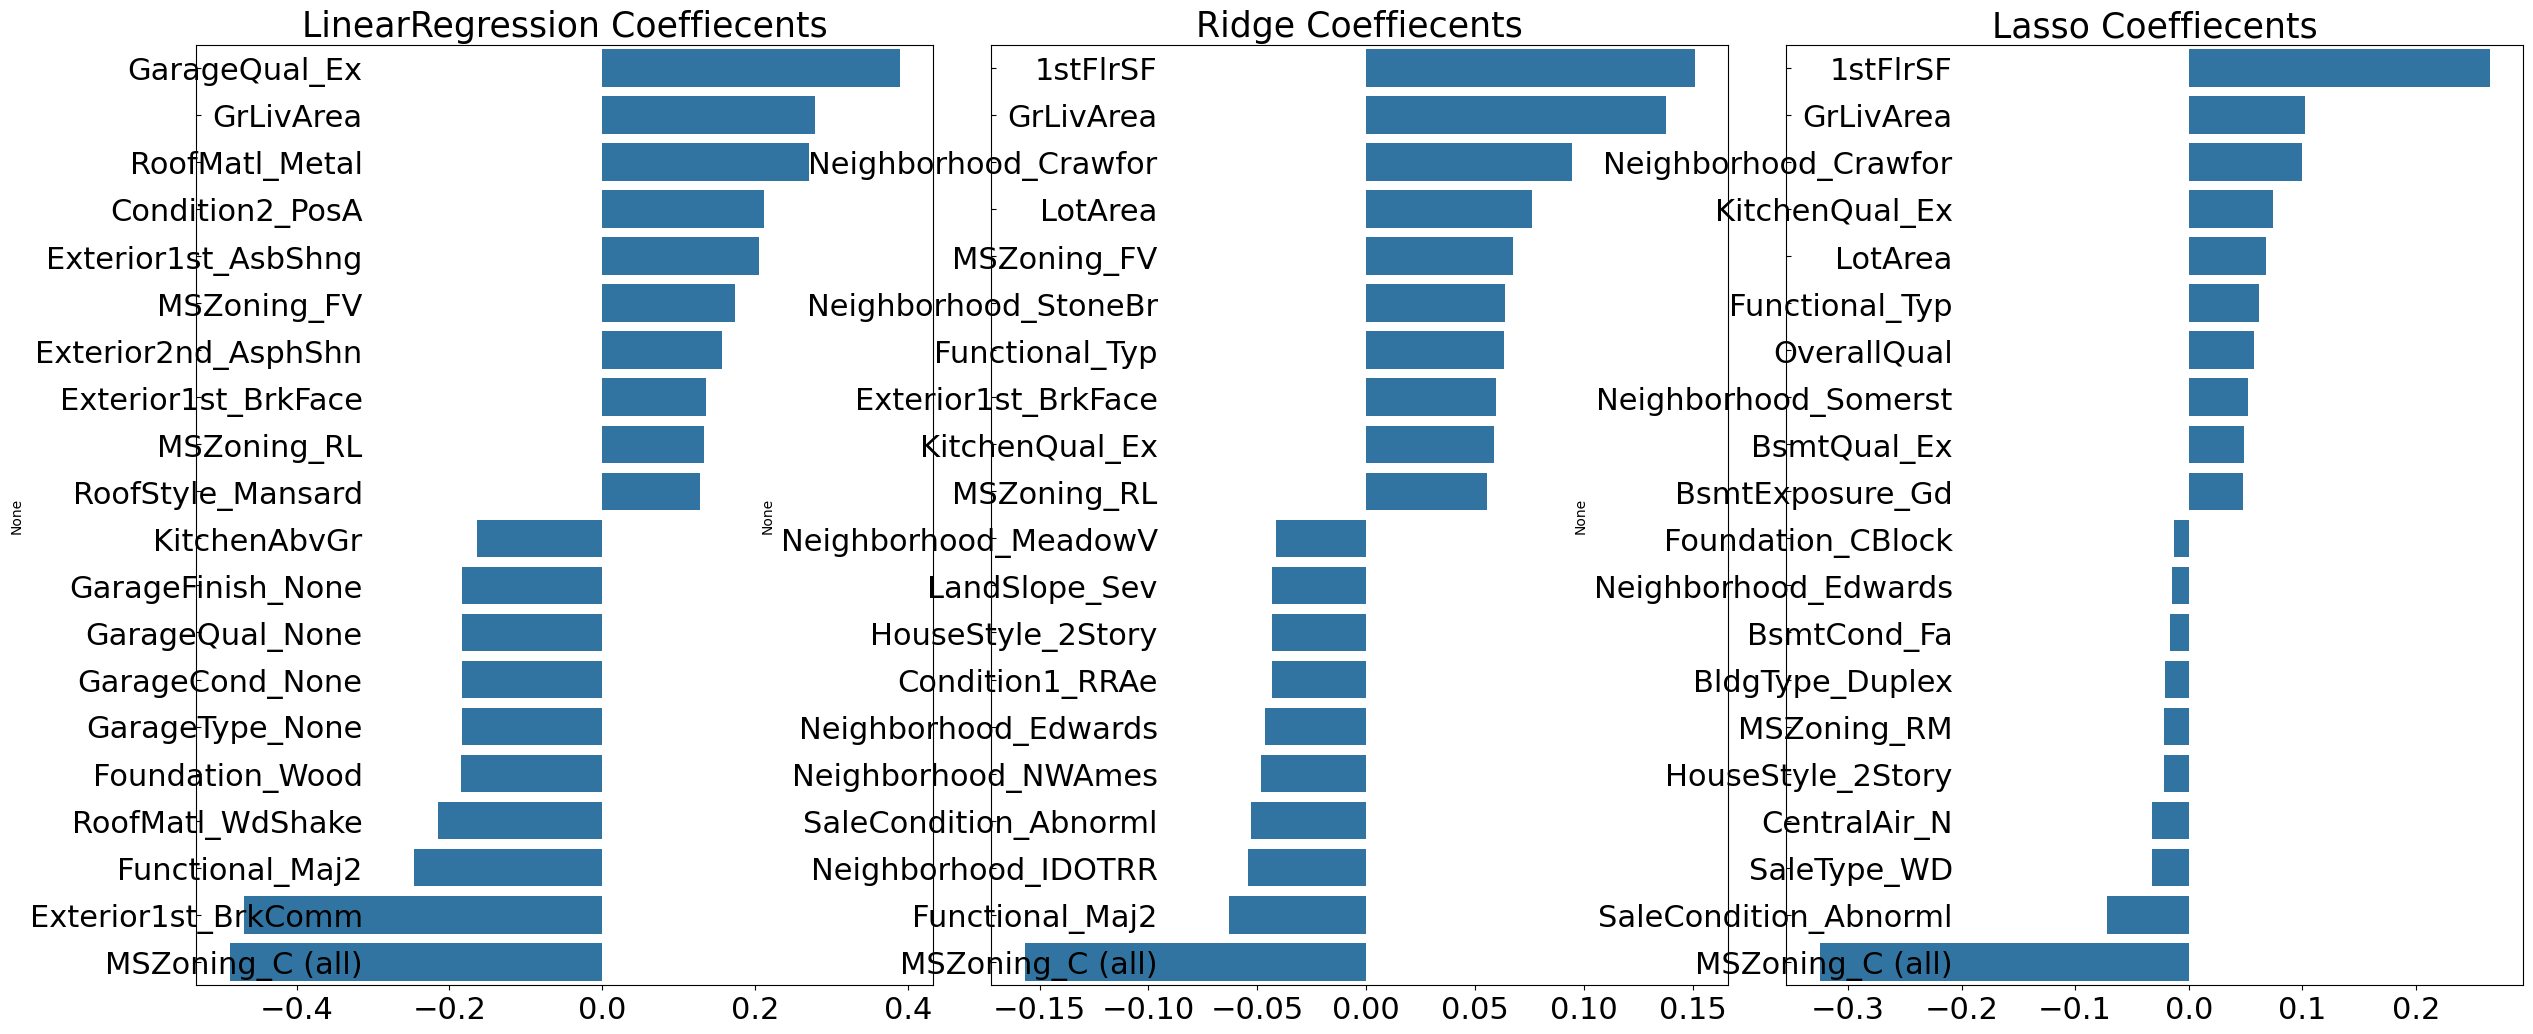

In [42]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## 회귀 트리 모델 학습/예측/평가

### LightGBM Regressor

In [54]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

# 튜닝 대상 파라미터
lgbm_params = {
    'n_estimators': [30, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    # 'num_leaves': [31, 64, 128],
}

# 모델 정의
lgbm_reg = LGBMRegressor(
    boost_from_average=False,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_reg, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_lgbm = GridSearchCV(lgbm_reg, lgbm_params, cv=3, scoring='neg_mean_squared_error')

# 학습 시 추가 fit_params 전달
grid_cv_lgbm.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_lgbm_grid = evaluate_best_model(grid_cv_lgbm, X_test, y_test)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
Best Cross-Validation Score (neg-MSE 기준): -0.02013469934378762

Test Evaluation
RMSE : 22482.3506
MSE  : 505456087.6501


### XGBoost

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 튜닝 대상 파라미터
xgb_param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# 모델 정의
xgb_reg = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=10,
    random_state=42,
    n_jobs=-1
)

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(
    xgb_reg, X_train, X_test, y_train, y_test
)

# RandomizedSearchCV 정의
random_cv_xgb = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습 시 추가 fit_params 전달
random_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_rand = evaluate_best_model(random_cv_xgb, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Cross-Validation Score (neg-MSE 기준): -0.018962331954270054

Test Evaluation
RMSE : 21204.2665
MSE  : 449620919.6577


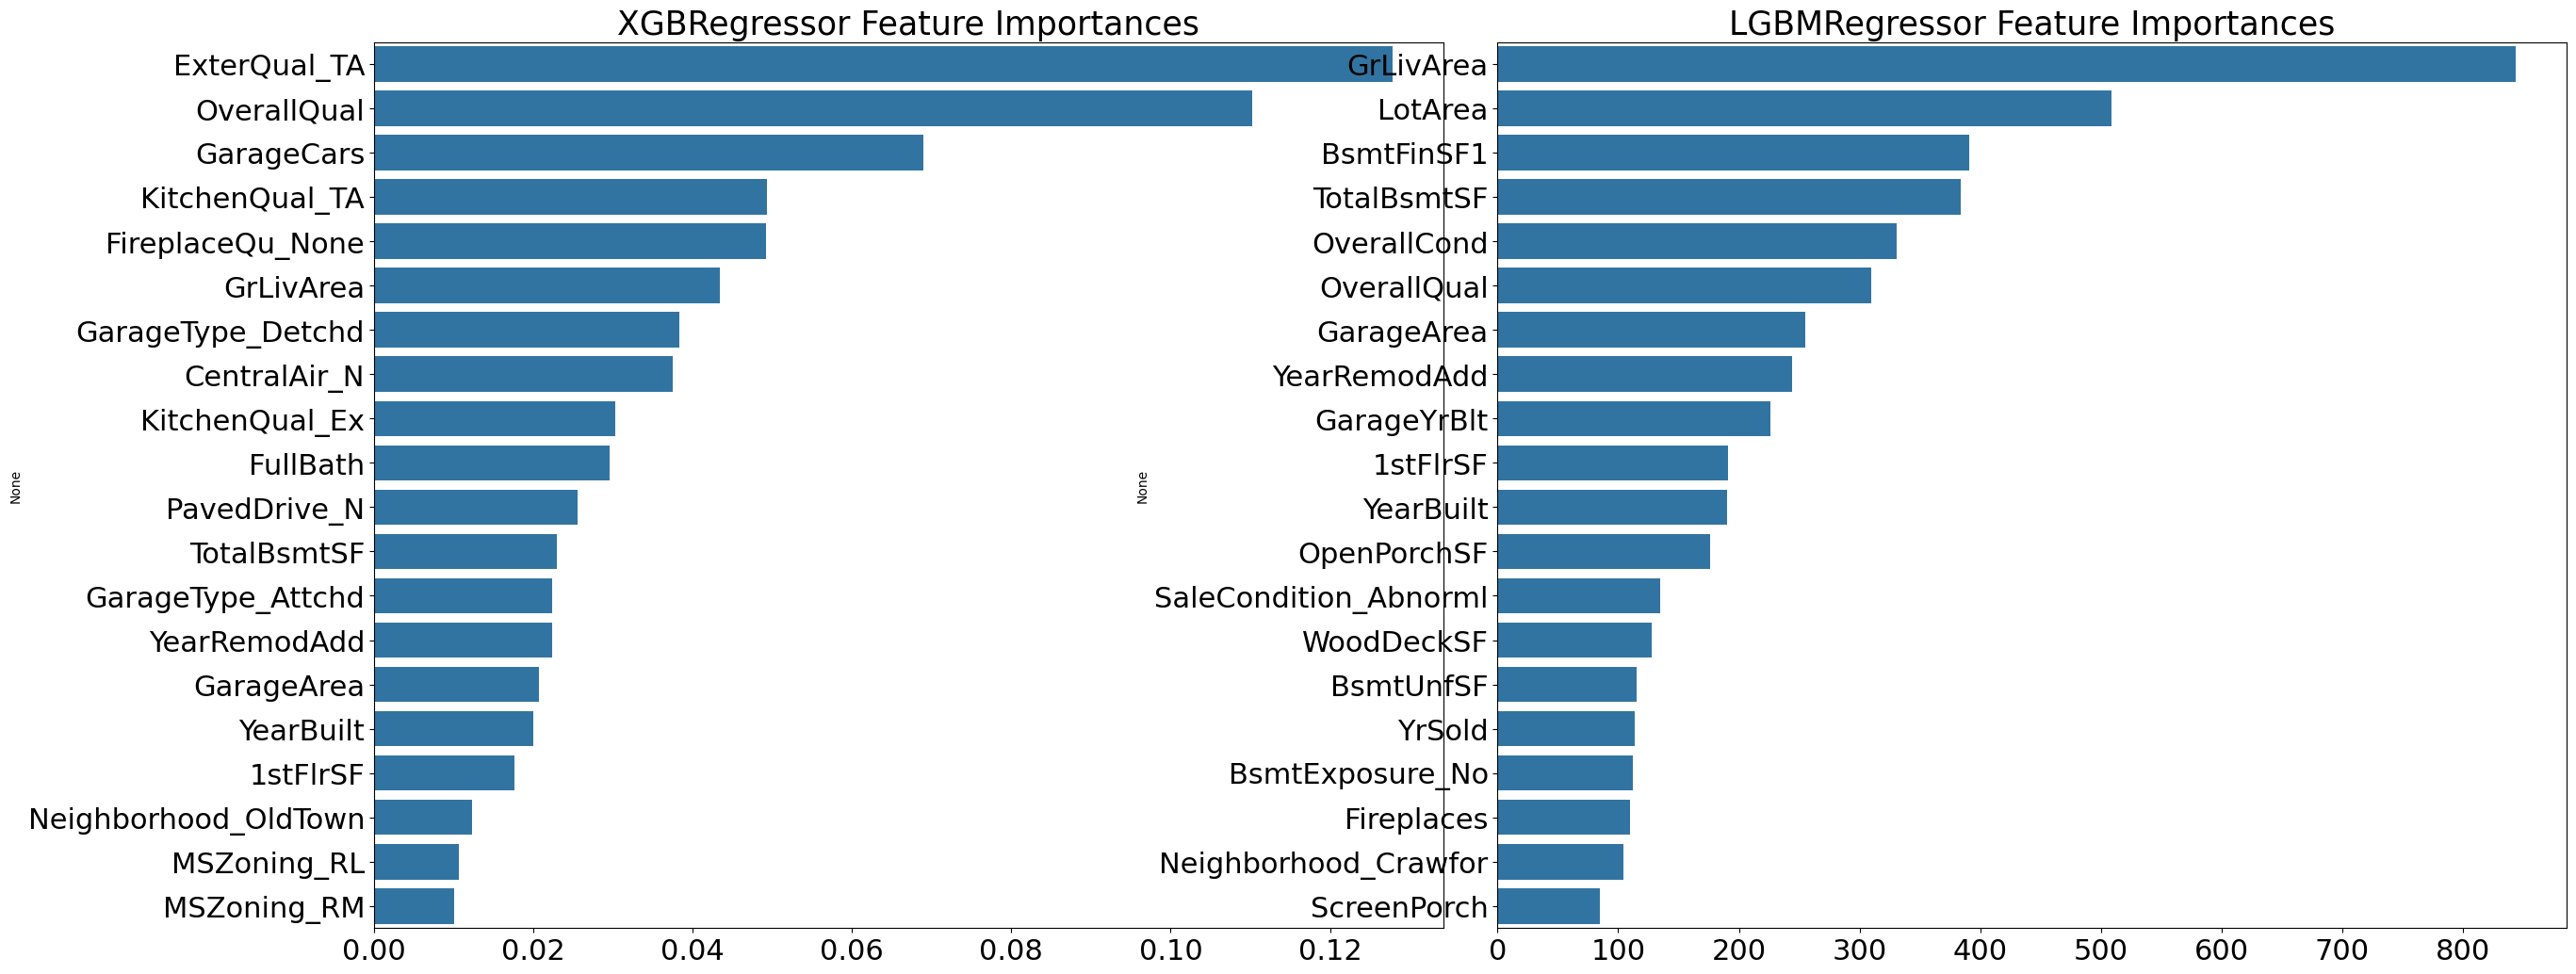

In [58]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화.
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb_rand, best_lgbm_grid]
visualize_ftr_importances(models)

## 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [59]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.11245123965435232
Ridge 모델의 RMSE: 0.11626789658809782
Lasso 모델의 RMSE: 0.11212319020373047


In [60]:
#LightGBM
#Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
#Best Cross-Validation Score (neg-MSE 기준): -0.02013469934378762
#XGBoost
#Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
#Best Cross-Validation Score (neg-MSE 기준): -0.018962331954270054

xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1,
                       colsample_bytree=0.8, subsample=0.8)

lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.01, num_leaves=4, max_depth=4,
                         #subsample=0.6, colsample_bytree=0.4, reg_lambda=10,
                         n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.11818310104605391
XGBM 모델의 RMSE: 0.1216682963486175
LGBM 모델의 RMSE: 0.12308398399728601


## 스태킹 앙상블 모델을 통한 회귀 예측

In [61]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [62]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [63]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train,
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.11151862102359213


# 제출용 Test 데이터 전처리 진행

### train에 진행된 전처리
- NUll 많은 컬럼 삭제
- skew 컬럼 로그 변환
- 원핫 인코딩

결과값의 컬럼 개수가 266개여야한다

또 test와 train의 원핫인코딩 이후 개수가 달라지는 현상이 발생하게되는데

이때는 값이 너무 많아서
```
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)
```
이런 방식으로 train과 열 개수를 맞춰주는 방식을 사용해봄
- 다른 방식을 사용해보셔도 좋습니다~

In [64]:
X_train.shape

(932, 286)

In [68]:
## test_data를 받아오기
test = pd.read_csv('Modulabs/test.csv')

In [69]:
# Null 이 1000개 이상인 컬럼 삭제
test.drop(['Id','PoolQC' , 'MiscFeature', 'Alley'], axis=1 , inplace=True)
## 1. 'Fence' 결측치를 최빈값으로 채움
test['Fence'] = test['Fence'].fillna('MnPrv')
# 2. 'MasVnrType'은 외장 석재를 말하며, 결측치는 외장석재가 없음을 의미하므로 'None으로 처리
test['MasVnrType'] = test['MasVnrType'].fillna('None')
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
# 3. FireplaceQu (벽난로 품질)
# - 결측치 의미: 벽난로가 없음 (즉, 품질이 없는 것이 아니라, 벽난로 자체가 없음)
# 처리 방법: 'None'으로 채우기
test['FireplaceQu'] = test['FireplaceQu'].fillna('None')
# 4. LotFrontage (도로에 접한 거리)
# - 측치 의미: 실제 측정 누락 또는 존재하지 않음
# 처리 방법: 동일한 Neighborhood(이웃 지역) 단위의 평균값으로 채우기
# 이웃 지역별 평균 LotFrontage로 결측치 채우기
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)
# 5. Garage 관련 (69건씩 결측)
# GarageType, GarageFinish, GarageQual, GarageCond	: 차고의 유형, 마감, 품질 등 => 'None' 으로 채우기
# GarageYrBlt	: 차고 건축 연도 => 0 또는 집의 건축연도(YearBuilt)로 채우기
# 범주형은 'None'으로
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
test[garage_cols] = test[garage_cols].fillna('None')
# GarageYrBlt는 0 또는 YearBuilt 사용
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

# 6. Basement 관련 결측치 - 지하실 없음
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
test[bsmt_cols] = test[bsmt_cols].fillna('None')

# 7. Electrical - 최빈값으로 채움 (1건 결측)
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
isnull_series = test.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
# test.fillna(test.mean(),inplace=True)
num_cols = test.select_dtypes(include=['number']).columns
num_cols
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())


Null 컬럼과 그 건수:
  Series([], dtype: int64)


In [70]:
num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# 편향 전처리 진행
test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape

(292, 286)

# 최적 모델 적용

In [71]:
X_train.columns.equals(test_ohe2.columns)

True

In [74]:
## sample_data를 받아오기
submission = pd.read_csv('Modulabs/sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
submission

,Id,SalePrice
0,86,0
1,227,0
2,492,0
3,64,0
4,576,0
...,...,...
287,1271,0
288,903,0
289,1019,0
290,312,0


In [87]:
pred = ridge_reg.predict(test_ohe2)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(test_ohe2)
lasso_pred = lasso_reg.predict(test_ohe2)

xgb_pred = xgb_reg.predict(test_ohe2)
lgbm_pred = lgbm_reg.predict(test_ohe2)

# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)
ridge_pred_exp = np.expm1(ridge_pred)
lasso_pred_exp = np.expm1(lasso_pred)
xgb_pred_exp = np.expm1(xgb_pred)
lgbm_pred_exp = np.expm1(lgbm_pred)

# 제출부분과 크기가 맞는지 확인
print(pred_exp.shape)
print(ridge_pred_exp.shape)
print(lasso_pred_exp.shape)
print(xgb_pred_exp.shape)
print(lgbm_pred_exp.shape)

# print(ridge_pred_exp)
# print(lasso_pred_exp)
# print(xgb_pred_exp)
# print(lgbm_pred_exp)

(292,)
(292,)
(292,)
(292,)
(292,)


In [89]:
# sample 파일에 예측 값을 넣어주고
submission["SalePrice"] = ridge_pred_exp

# csv로 저장하기
submission.to_csv("./submission_ridge.csv", index=False) #21518

# SalePrice 날리기
submission.drop(['SalePrice'], axis=1 , inplace=True)



# sample 파일에 예측 값을 넣어주고
submission["SalePrice"] = lasso_pred_exp

# csv로 저장하기
submission.to_csv("./submission_lasso.csv", index=False) #22641

# SalePrice 날리기
submission.drop(['SalePrice'], axis=1 , inplace=True)



# sample 파일에 예측 값을 넣어주고
submission["SalePrice"] = xgb_pred_exp

# csv로 저장하기
submission.to_csv("./submission_xgb.csv", index=False) #26739

# SalePrice 날리기
submission.drop(['SalePrice'], axis=1 , inplace=True)




# sample 파일에 예측 값을 넣어주고
submission["SalePrice"] = lgbm_pred_exp

# csv로 저장하기
submission.to_csv("./submission_lgbm.csv", index=False) #26672

# SalePrice 날리기
submission.drop(['SalePrice'], axis=1 , inplace=True)

## late submission 결과 = Ridge 가 best...

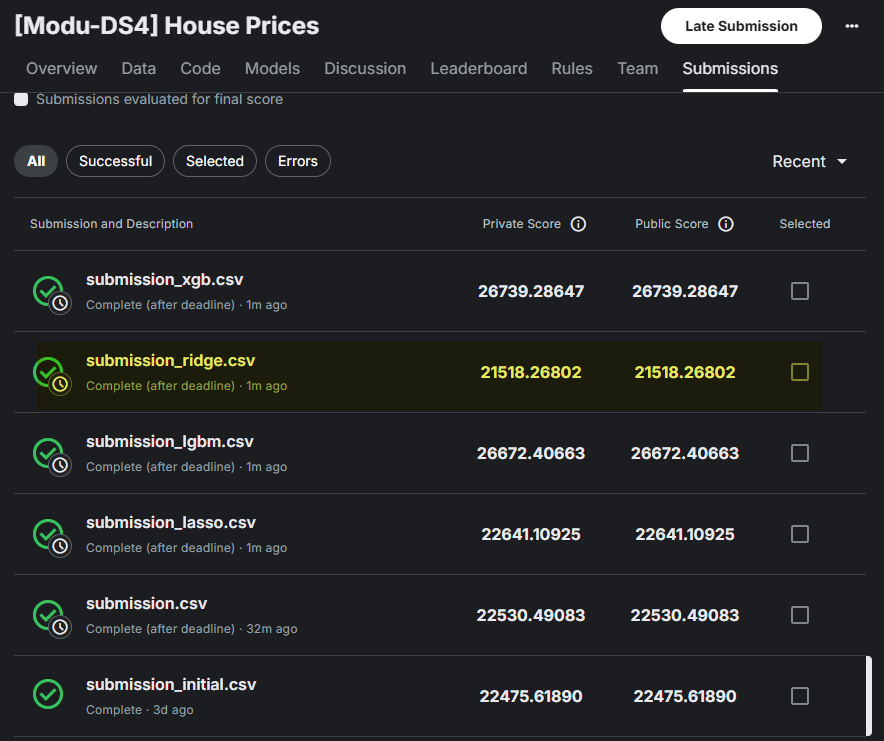